# Text-Level Analysis
Jana Bruses | janabruses@pitt.edu | University of Pittsburgh | Apr 21st - ...

Second notebook of the Analysis portion of the project.\
First notebook found at: [Analysis-1-LowLevel](http://localhost:8888/notebooks/Linguistic-Markers-Catalan-Substitution/Analysis-1-LowLevel.ipynb)\
Fourth notebook of the project, after the [data portion](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/blob/main/Data-Parsing-Exploratory-Analysis-2.ipynb) notebook.

In this analysis notebook various machine learning models were used to analyze the linguistic changes that could indicate Catalan's substitution explored in [Analysis-1-LowLevel](http://localhost:8888/notebooks/Linguistic-Markers-Catalan-Substitution/Analysis-1-LowLevel.ipynb) namely:\
"hi" percentage - to analyze loss of word classes\
passat perifràstic vs passat simple - to analyze time lexicon modification\
anar vs venir percentage - to analyze space lexicon modification\
verb pronominalization - to analyze syntactic Restructuring\

All the data used in the analysis steps was included in the dataframe and pickled at the end of the analysis.\
The data will now be loaded.

Contents on this analysis notebook:\
**1** Before vs After Franquism Catalan\
**2** Time clusters according to the various features\

In [2]:
# loading libraries
import pandas as pd
import numpy as np

Our data, is split in two main periods, before Franquism and after Franquism. We have two blocks of data. From 1860 to 1926 and from 1985 to 2022. We will label this two periods as 1926b and 1985a and have a classifier distinguish them, to look for other features that could tell us more about Catalan's substitution.

In [2]:
# loading the pickled complete dataframe
tokscomplete_df = pd.read_pickle("tokcomplete_df.pkl")
tokscomplete_df = tokscomplete_df.drop_duplicates(subset="Text", keep="first")

In [3]:
def period_tagger(year):
    if year <= 1926:
        return "1926b"
    elif year >= 1985:
        return "1985a"
    else:
        print(year) #printing any years not in that range to check

In [4]:
tokscomplete_df["Period"] = tokscomplete_df["Year"].apply(period_tagger)

In [5]:
tokscomplete_df["Period"].value_counts()

Period
1985a    64916
1926b       28
Name: count, dtype: int64

**Comment:**
As this numbers portray, we have a huge amount of data for the recent period, while we have very few documents for the period from 1926 and earler. However, since these are ceremonial speeches, looking at the length in tokens might actually be more informative. 

In [6]:
tokscomplete_df.groupby("Period")["Len_toks"].sum()

Period
1926b     143831
1985a    2803938
Name: Len_toks, dtype: int64

**Comment:** The gap is not that big, as many of the later contributions are short, have single lines and a little amount of words, while the few documents from before 1926 are complete speeches. 

Because of this, instead of having the classifier classify full pieces of text, we will use single sentences as the text features. 

In [7]:
def sent_tokenize(content):
    doc = nlp(content)
    sent_list = [sentence.text for sentence in doc.sentences]
    return sent_list

In [8]:
# from tqdm import tqdm
# tqdm.pandas()  # activa el suport per apply
# import stanza
# nlp = stanza.Pipeline(lang='ca', processors='tokenize')
# tokscomplete_df["Sent_toks"] = tokscomplete_df["Text"].progress_apply(sent_tokenize)

In [9]:
senttok_df = pd.read_pickle("sent_tok.pkl")

In [10]:
sent_tokens_example = senttok_df[senttok_df["Year"] == 1860]["Sent_toks"].iloc[0]

In [11]:
sent_tokens_example[0]

'Breu seré, cuant ja se han complagut vostres oídos ab los melodiosos cants de tants trovadors inspirats per lo esperit de la Religió, per lo amor de la patria y per lo amor á la bellesa ¿Qué podria jo anyadir cuant sento ja escapar de mon esperit la última espurna del juvenil entusiasme?'

In [12]:
sent_tokens_example[1]

'Tant sols me cap lo expressar ab curtas frases lo goig que inunda mon cor al véurervos per segona vegada reunits en aquesta festa de familia, renovant memorias tan dolsas, evocant noms tan estimats, y recordant dias tan gloriosos pera nostra antiga patria.'

In [13]:
# re-doing the period tag on the sentence tokenized dataframe
senttok_df["Period"] = senttok_df["Year"].apply(period_tagger)

In [14]:
senttok_df["Sent_count"] = senttok_df["Sent_toks"].apply(lambda sents: len(sents))

In [15]:
senttok_df.groupby("Period")["Sent_count"].sum()

Period
1926b      2835
1985a    199697
Name: Sent_count, dtype: int64

In [16]:
senttok_df["Sent_count"].sum()

202532

In [17]:
# basline is incredibly high
199697/202532

0.986002211996129

In [18]:
def tag_sents(sent_list, period_tag):
    return ([(s, period_tag) for s in sent_list])

In [19]:
# tagging the sentences
senttok_df["tagged_sents"] = senttok_df.apply(lambda row: tag_sents(row["Sent_toks"], row["Period"]), axis=1)

In [20]:
# separating them into two lists
sents_1926b = [sent for sentence_list in senttok_df["tagged_sents"] for sent in sentence_list if sent[1]=="1926b"]
sents_1985a = [sent for sentence_list in senttok_df["tagged_sents"] for sent in sentence_list if sent[1]=="1985a"]

In [21]:
print(sents_1926b[0])
sents_1985a[0]

("L'home que per amor al estudi, impulsat per un imperatiu ineludible 's manté reclòs en el seu laboratori o en la biblioteca, treballant sense parar may, indiferent a les temptacions mondanes, es certament un hèroe.", '1926b')


('perquè que el president de catalunya sigui rebut pel president de la comissió europea',
 '1985a')

In [22]:
sents = sents_1926b+sents_1985a

import random
random.Random(10).shuffle(sents)

In [23]:
tagged_df = pd.DataFrame(sents, columns=["sentence", "tag"])

In [24]:
# creating traning and testing partitions
from sklearn.model_selection import train_test_split
docs_train, docs_test, y_train, y_test = train_test_split(tagged_df["sentence"], tagged_df["tag"], test_size = 0.20, random_state = 0)

In [25]:
# examining resulting partitions 
print(len(docs_train), len(docs_test))
print(len(y_train), len(y_test))
print()
print(sorted(set(y_train)))
print(sorted(set(y_test)))

162025 40507
162025 40507

['1926b', '1985a']
['1926b', '1985a']


In [26]:
import sklearn
from sklearn.pipeline import make_pipeline

# for Naïve Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# will consist of 2 steps
# step 1: feature extraction through tf-idf
# step 2: naive bayes multinomial model
period_nbc = make_pipeline(TfidfVectorizer(max_features = 1500), MultinomialNB())

# fitting and training model through pipeline 
period_nbc.fit(docs_train, y_train) # fitting model (training sents, target labels)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=1500)),
                ('multinomialnb', MultinomialNB())])

In [27]:
# creating predicted labels
y_pred_prompt_nb = period_nbc.predict(docs_test)

In [28]:
# evaluating
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

In [29]:
# checking accuracy score
accuracy_score(y_test, y_pred_prompt_nb)

0.9908904633767003

<function matplotlib.pyplot.show(close=None, block=None)>

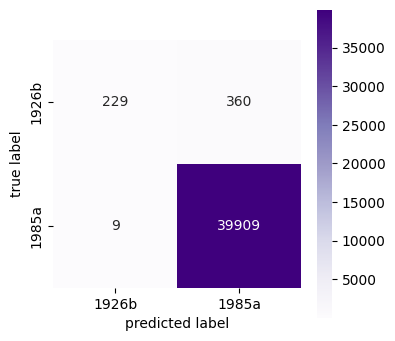

In [30]:
import matplotlib.pyplot as plt
mtrx_prompt_nb = confusion_matrix(y_test, y_pred_prompt_nb)
# plotting confusion matrix
plt.figure(figsize = (4, 4))
sns.heatmap(mtrx_prompt_nb, square = True, annot = True, fmt = 'd', cmap = "Purples", 
            xticklabels= sorted(set(y_train)), yticklabels= sorted(set(y_pred_prompt_nb)))
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show

**Comment:** Since this division is very uneven, let's try to cluster our data in smaller periods hoping for a more descriptive model for our analysis.

## Clustering
Since we need to divide the data in periods, we will try to find the optimal number of clusters. However, since we want the clusters to be a continuous period (eg.: we don't want 1860 and 1867 to be clustered together if 1865 belongs to another cluster) we will need to use **Ward hierarchical clustering** as it allows for connectivity constraints.
The following Clustering process has been done following:\
[Scikit-learn User Guide 2.3. on Clustering](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)\
[DataCamp's Introduction to Hierarchical Clustering](https://www.datacamp.com/tutorial/introduction-hierarchical-clustering-python)\
[DataCamp's Cluster Analysis in Python](https://app.datacamp.com/learn/courses/cluster-analysis-in-python)

In [3]:
# loading the complete dataframe
complete_df = pd.read_pickle("complete_df.pkl")

In [4]:
# checking its columsn
complete_df.columns

Index(['Year', 'Line_id', 'Text', 'Text_len', 'toks', 'Len_toks', 'toks_low',
       'hi', '-hi', 'hi_count', 'hi_percent', 'Lemmas', 'Anar_count',
       'Venir_count', 'Anar_percent', 'Venir_percent', 'PstPerif',
       'Pstp_count', 'Pstp_percent', 'HaverDe_count', 'TenirQue_count', 'POS',
       'PronominalizedV', 'PronV_count', 'V_total', 'PronV_percent'],
      dtype='object')

In [6]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12093636 entries, 0 to 12093635
Data columns (total 26 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Year             int64  
 1   Line_id          object 
 2   Text             object 
 3   Text_len         int64  
 4   toks             object 
 5   Len_toks         int64  
 6   toks_low         object 
 7   hi               object 
 8   -hi              object 
 9   hi_count         int64  
 10  hi_percent       float64
 11  Lemmas           object 
 12  Anar_count       int64  
 13  Venir_count      int64  
 14  Anar_percent     float64
 15  Venir_percent    float64
 16  PstPerif         object 
 17  Pstp_count       int64  
 18  Pstp_percent     float64
 19  HaverDe_count    int64  
 20  TenirQue_count   int64  
 21  POS              object 
 22  PronominalizedV  object 
 23  PronV_count      int64  
 24  V_total          int64  
 25  PronV_percent    float64
dtypes: float64(5), int64(11), object(10)
mem

### Getting the data ready for clustering

In [7]:
# keeping only the columns we want (percentages, which are floats and a single int which is the Year (will be turned into the target)
df = complete_df[["Year", "hi_percent", "Anar_percent", "Venir_percent", "Pstp_percent", "PronV_percent"]]
# add haver de i tenir que

In [8]:
df.head(3)

,Year,hi_percent,Anar_percent,Venir_percent,Pstp_percent,PronV_percent
0,1926,0.013761,0.839411,0.027522,0.481629,4.732824
1,1920,0.053619,0.428954,0.000000,0.214477,10.596026
2,1900,0.006790,0.129015,0.033951,0.040741,8.818636
3,1894,0.017200,0.171999,0.189198,0.103199,1.344538
4,1894,0.017200,0.171999,0.189198,0.103199,6.557377


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12093636 entries, 0 to 12093635
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Year           int64  
 1   hi_percent     float64
 2   Anar_percent   float64
 3   Venir_percent  float64
 4   Pstp_percent   float64
 5   PronV_percent  float64
dtypes: float64(5), int64(1)
memory usage: 553.6 MB


**Comment:** We have a huge amount of data that can't be used for hierarchical clustering. Therefore, we will create a sample of data and work with it from now on in this part of the analysis. 

In [10]:
# sampling data because we have too much data to work with to do hierarchical clustering
sample_data = []

for year in sorted(df['Year'].unique()):
    yearly_data = df[df['Year'] == year]
    sample = yearly_data.sample(n=min(1000, len(yearly_data)), random_state=0)
    sample_data.append(sample)

sample_data = pd.concat(sample_data)

In [11]:
sample_data.describe()

,Year,hi_percent,Anar_percent,Venir_percent,Pstp_percent,PronV_percent
count,22724.000000,22724.000000,22724.000000,22724.000000,22724.000000,22724.000000
mean,2000.524864,0.260201,0.648009,0.079691,0.310040,14.575382
std,13.742399,0.934629,1.763867,0.557314,1.201793,23.248500
min,1860.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1994.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2002.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2008.000000,0.000000,0.403277,0.000000,0.000000,22.222222
max,2022.000000,25.000000,33.333333,25.000000,25.000000,100.000000


In [12]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22724 entries, 204 to 4440
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           22724 non-null  int64  
 1   hi_percent     22724 non-null  float64
 2   Anar_percent   22724 non-null  float64
 3   Venir_percent  22724 non-null  float64
 4   Pstp_percent   22724 non-null  float64
 5   PronV_percent  22724 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.2 MB


**Comment:** Our data is remarkably smaller, with now about 22000 entries compared to the initial 12093636, and reducng its size from 553.6MB to 1.2MB.

Normally the next step would be to remove any outliers. However, in our case, that would mean throwing away most of the early years, which is not ideal since we want to look at a historical change. Therefore, we won't be removing outliers but will need to keep it in mind as it will likely squeue our data. 

Since our goal is to see how the different linguistic features cluster our data, we will normalize the data by column/feature.

In [13]:
# normalizing data per column/feature
from sklearn.preprocessing import StandardScaler

features = ["hi_percent", "Anar_percent", "Venir_percent", "Pstp_percent", "PronV_percent"]

scaler = StandardScaler()
sample_data[features] = scaler.fit_transform(sample_data[features])

In [14]:
sample_data.describe()

,Year,hi_percent,Anar_percent,Venir_percent,Pstp_percent,PronV_percent
count,22724.000000,22724.000000,2.272400e+04,2.272400e+04,2.272400e+04,2.272400e+04
mean,2000.524864,0.000000,2.001177e-17,8.755147e-18,-2.501471e-17,-1.751029e-17
std,13.742399,1.000022,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00
min,1860.000000,-0.278406,-3.673877e-01,-1.429938e-01,-2.579868e-01,-6.269524e-01
25%,1994.000000,-0.278406,-3.673877e-01,-1.429938e-01,-2.579868e-01,-6.269524e-01
50%,2002.000000,-0.278406,-3.673877e-01,-1.429938e-01,-2.579868e-01,-6.269524e-01
75%,2008.000000,-0.278406,-1.387505e-01,-1.429938e-01,-2.579868e-01,3.289248e-01
max,2022.000000,26.470760,1.853090e+01,4.471597e+01,2.054473e+01,3.674495e+00


**Comment:** Since hierarchical clustering uses Euclidean distance, which is sensitive to scale, we need to rescale all the variables before computing the distance.

In [36]:
# sorting the values and scaling the features
X = sample_data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_sorted = sample_data.sort_values("Year").reset_index(drop=True)
X_sorted = X_scaled[df_sorted.index]
X_sorted[:10] 

array([[-0.27840595, -0.36738767,  0.04411341, -0.25798683, -0.58138623],
       [-0.27840595, -0.36738767,  0.04411341, -0.25798683, -0.48592134],
       [-0.27840595, -0.36738767,  0.04411341, -0.25798683, -0.56608287],
       [-0.27840595, -0.36738767,  0.04411341, -0.25798683, -0.41321589],
       [-0.27840595, -0.36738767,  0.04411341, -0.25798683, -0.38963117],
       [-0.27840595, -0.36738767,  0.04411341, -0.25798683, -0.56997959],
       [-0.27840595, -0.36738767,  0.04411341, -0.25798683, -0.30243492],
       [-0.27840595, -0.36738767,  0.04411341, -0.25798683, -0.34489028],
       [-0.27840595, -0.36738767,  0.04411341, -0.25798683, -0.40291869],
       [-0.27840595, -0.36738767,  0.04411341, -0.25798683, -0.38487961]])

**Comment:** After scaling the data the next step is stablishing the constraint which is known as "conectivity" in Ward linkage for hyerarchical clustering. In our case, that is that **only neighboring years can be in the same cluster**, as we need to allow 1900-1901-1902 to be in the same cluster but not 1900-1902 if 1901 is in another cluster.

In [37]:
# ensuring only neighboring years can be in same cluster
# based on https://scikit-learn.org/stable/auto_examples/cluster/plot_ward_structured_vs_unstructured.html
# done through a kneighbors_graph
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(sample_data, n_neighbors=2, include_self=False)

In [30]:
# computing structured hierarchical clustering
import time as time
from sklearn.cluster import AgglomerativeClustering
st = time.time()
ward = AgglomerativeClustering(n_clusters=5, connectivity=connectivity, linkage="ward").fit(sample_data)

elapsed_time = time.time() - st
label = ward.labels_
print(f"Elapsed time: {elapsed_time:.2f}s")
print(f"Number of points: {label.size}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 1243 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


KeyboardInterrupt: 

In [ ]:
sample_data["period_cluster"] = ward.fit_predict(sample_data)

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(sample_data, sample_data["period_cluster"])

In [ ]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(121, projection="3d", elev=7, azim=-80)
ax2.set_position([0, 0, 0.95, 1])
for l in np.unique(label):
    ax2.scatter(
        X[label == l, 0],
        X[label == l, 1],
        X[label == l, 2],
        color=plt.cm.jet(float(l) / np.max(label + 1)),
        s=20,
        edgecolor="k",
    )
fig2.suptitle(f"With connectivity constraints (time {elapsed_time:.2f}s)")

plt.show()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplot_mosaic([["A", "B"],  # A-hi & B-PassatPerifràstic
                              ["C", "D"],  # C-venir & D-anar
                              ["E", "E"]],  # Pronominal Verbs 
                             figsize=(10, 8),
                             constrained_layout=True)

# (A) Clustering of years acording to the percentage of hi respect to the token count
for cluster in sorted(sample_data["period_cluster"].unique()):
    subset = sample_data[sample_data["period_cluster"] == cluster]
    ax["A"].plot(subset["Year"], subset["hi_percent"], label=f"Cluster {cluster}")
    
ax["A"].legend()
ax["A"].set_title("hi_percent over time by cluster")
ax["A"].set_xlabel("Year")
ax["A"].set_ylabel("hi_percent")

# (B) Clustering of years acording to the percentage of Passat Perifràstic respect to the token count
for cluster in sorted(sample_data["period_cluster"].unique()):
    subset = sample_data[sample_data["period_cluster"] == cluster]
    ax["B"].plot(subset["Year"], subset["Pstp_percent"], label=f"Cluster {cluster}")
    
ax["B"].legend()
ax["B"].set_title("Pstp_percent over time by cluster")
ax["B"].set_xlabel("Year")
ax["B"].set_ylabel("Pstp_percent")

# (C) Clustering of years acording to the percentage of Venir respect to the token count
for cluster in sorted(sample_data["period_cluster"].unique()):
    subset = sample_data[sample_data["period_cluster"] == cluster]
    ax["C"].plot(subset["Year"], subset["Anar_percent"], label=f"Cluster {cluster}")
    
ax["C"].legend()
ax["C"].set_title("Anar_percent over time by cluster")
ax["C"].set_xlabel("Year")
ax["C"].set_ylabel("Anar_percent")

# (D) Clustering of years acording to the percentage of Anar respect to the token count
for cluster in sorted(sample_data["period_cluster"].unique()):
    subset = sample_data[sample_data["period_cluster"] == cluster]
    ax["D"].plot(subset["Year"], subset["Venir_percent"], label=f"Cluster {cluster}")
    
ax["D"].legend()
ax["D"].set_title("Venir_percent over time by cluster")
ax["D"].set_xlabel("Year")
ax["D"].set_ylabel("Venir_percent")

# (E) Clustering of years acording to the percentage of Pronominal Verbs respect to the token count
for cluster in sorted(sample_data["period_cluster"].unique()):
    subset = sample_data[sample_data["period_cluster"] == cluster]
    ax["E"].plot(subset["Year"], subset["PronV_percent"], label=f"Cluster {cluster}")
    
ax["E"].legend()
ax["E"].set_title("PronV_percent over time by cluster")
ax["E"].set_xlabel("Year")
ax["E"].set_ylabel("PronV_percent")

# displaying
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Assume X is a NumPy array or DataFrame of shape (n_years, n_features), sorted by year
# Optionally: preprocess X to ensure each row represents one year (1860 to 2022)
years = np.arange(1860, 2023)
X = sample_data  # Shape: (163, n_features), sorted by years

results = []
ks = range(2, 20)  # Try cluster sizes from 2 to 20

for k in ks:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X)
    
    # Evaluate quality
    score = silhouette_score(X, labels)  # Or another score
    results.append(score)

# Plot results
plt.figure(figsize=(8, 4))
plt.plot(ks, results, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Optimization of Time Clustering")
plt.grid(True)
plt.show()